# The London Railway Network

The cell below defines the abstract class whose API you will need to impement. Do NOT modify it.

In [1]:
# DO NOT MODIFY THIS CELL

from abc import ABC, abstractmethod  

class AbstractLondonRailwayMapper(ABC):
    
    # constructor
    @abstractmethod
    def __init__(self):
        pass           
        
    # data initialisation
    @abstractmethod
    def loadStationsAndLines(self):
        pass

    # returns the minimum number of stops to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # numStops : int
    @abstractmethod
    def minStops(self, fromS, toS):     
        numStops = -1
        return numStops    
    
    # returns the minimum distance in miles to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # minDistance : float
    @abstractmethod
    def minDistance(self, fromS, toS):
        minDistance = -1.0
        return minDistance
    
    # given an unordered list of station names, returns a new railway line 
    # (represented as a list of adjacent station names), connecting all such stations 
    # and such that the sum of the distances (in miles) between adjacent stations is minimised
    # inputList : set<str>
    # outputList : list<str>
    @abstractmethod
    def newRailwayLine(self, inputList):
        outputList = []
        return outputList

Use the cell below to define any data structure and auxiliary python function you may need. Leave the implementation of the main API to the next code cell instead.

In [2]:
# ADD YOUR DATA STRUCTURE DEFINITIONS AND HELPER CODE HERE
#### Data Structures ####

from math import sqrt,cos, sin, radians, sqrt, atan2, pi
from matplotlib import pyplot as plt

def harvensineDistance(lat1, lng1, lat2, lng2):
    earthRadius = 3958.7613322984894 # earth's radius in miles
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    lng2 = radians(lng2)
    lng1 = radians(lng1)

    dLat = lat2-lat1;
    dLng = lng2-lng1;
    a = sin(dLat/2) * sin(dLat/2) + cos(lat1) * cos(lat2) * sin(dLng/2) * sin(dLng/2);
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return earthRadius * c

class PQ:
    """
    Min-Oriented Prioirty Queue implemented with binary heap
    """

    def __init__(self):
        self.values = []
    
    def insert(self, value):
        # inserts new value at the very end and swim up if the value is less than the value above in the heap
        self.values.append(value)
        self.__swim_up(len(self.values) - 1)

    def delMin(self):

        if len(self.values) == 0: 
            return None

        # swap the first and last element of the values
        self.__swap(0, len(self.values) - 1)
        output = self.values.pop()
        
        # sink the new swapped value that is at the top of the heap down
        self.__sink(0)
        
        return output

    def size(self):
        return len(self.values)
    
    def contains(self, targetValue):
        for value in self.values:
            if value == targetValue:
                return True
        return False

    def isEmpty(self):
        return self.size() == 0


    def __sink(self, targetIndex):
        
        queueSize = len(self.values)


        while True:
            leftIndex = 2 * targetIndex + 1
            rightIndex = 2 * targetIndex + 2

            smaller = leftIndex

            if rightIndex < queueSize and self.values[rightIndex] < self.values[smaller]:
                smaller = rightIndex
            
            # needs to be >= here because the case of just two values
            if leftIndex >= queueSize or self.values[smaller] > self.values[targetIndex]:
                break

            self.__swap(smaller, targetIndex)
            targetIndex = smaller

    def decreaseKey(self, targetValue, priority):
            """
            Decrease the priority of an existing value inside the queue
            
            This is used when the value is already inside the queue,
            instead of adding an extra item to the queue decrease the existing one instead
            """
            index = 0
            for value in self.values:
                if value == targetValue:
                    value.priority = priority
                    self.__swim_up(index)
                    # self.__sink(index)
                index += 1


    def __swim_up(self, targetIndex):
        parent_index = (targetIndex - 1) // 2

        while self.values[targetIndex] < self.values[parent_index] and targetIndex > 0:

            self.__swap(parent_index, targetIndex)

            targetIndex = parent_index
            parent_index = (targetIndex - 1) // 2


    def __swap(self, firstIndex, secondIndex):
        tmp = self.values[firstIndex]
        self.values[firstIndex] = self.values[secondIndex]
        self.values[secondIndex] = tmp



class PQItem:
    """
    Wrapper Data type to facilitate storing value, where the value is not necessarily its weight
    
    ie, (any, 3) the value is anything, but the weight would be 3, useful for string vertex id and the value to go 
    to it
    
    """
    def __init__(self, name, priority):
        self.name = name
        self.priority = priority
    
    def __eq__(self, name):
        return self.name == name
    
    def __ge__(self, other):
        return self.priority >= other.priority

    def __gt__(self, other):
        return self.priority > other.priority
    
    def __le__(self, other):
        return self.priority <= other.priority
    
    def __lt__(self, other):
        return self.priority < other.priority

class Graph:
    """
    Adjacency List Graph Representation
    """
    def __init__(self, V):
        self.V = V
        self.adj = []
        for _ in range (0, V):
            self.adj.append([])

    def addEdge(self, e):
        v = e.endPoint()
        w = e.otherEndPoint(v)
        self.adj[v].append(e)
        # self.adj[w].append(e)
        # we have to swap here because we have to relax its outgoing edges, 
        # if we don't swap the direction around it would relax the wrong end
        # i.e vertex 0 has edge 0 -> 1, but vertex 1 would also has edge 0 -> 1 if we don't swap it around
        self.adj[w].append(e.swap())

    def adjacencies(self, v):
        return self.adj[v]



class Edge:
    """
    Edge Representation for the graph
    
    Overwritten the comparison methods to use the edge's weight
    for ease of comparing when added to a priority queue
    
    """
    def __init__(self, v, w, weight):
        self.v = v
        self.w = w
        self.weight = weight

    def endPoint(self):
        return self.v

    def otherEndPoint(self, vertex):
        if vertex == self.v:
            return self.w
        return self.v

    def same(self, e):
        return self.v == e.endPoint() and self.w == e.otherEndPoint(e.endPoint()) and self.weight == e.getWeight()

    def getWeight(self):
        return self.weight

    def swap(self):
        return Edge(self.w, self.v, self.weight)
    
    def __str__(self):
        return f"v: {self.v}, w: {self.w}, weight: {self.weight}"
    
    def __eq__(self, other):
        return self.weight == other.weight
    
    def __ge__(self, other):
        return self.weight >= other.weight

    def __gt__(self, other):
        return self.weight > other.weight
    
    def __le__(self, other):
        return self.weight <= other.weight
    
    def __lt__(self, other):
        return self.weight < other.weight
    
class Queue():
    def __init__(self):
        self.queue = []
    
    def isEmpty(self):
        return self.queue == []
    
    def enqueue(self, item):
        self.queue.append(item)
    
    def dequeue(self):
        return self.queue.pop(0)
    
    def size(self):
        return len(self.queue)
    
class StationInfo:

    def __init__(self, station_id, name, lat, lng):
        self.station_id = station_id
        self.name = name
        self.lat = float(lat)
        self.lng = float(lng)
    
    def getName(self):
        return self.name

    def __str__(self):
        return f"station_id: {self.station_id}, latitude: {self.lat}, longitude: {self.lng}"
    


In [3]:
#### Algorithms ####

class BFS:
    """
    Breath-First-Search Algorithm
    """
    def __init__(self, G, s):
        self.starting = s
        self.distToSource = [-1 for v in range(0, G.V)]
        self.edgeTo = [-1 for v in range(0, G.V)]
        self.__bfs(G, s)

    def __bfs(self, G, s):
        q = Queue()
        q.enqueue(s)
        self.distToSource[s] = 0
        while(not q.isEmpty()):
            v = q.dequeue()
            
            self.__traverseEdges(q, v, G)
                    
    def __traverseEdges(self,q, v, G):
        for w in G.adjacencies(v):
            
            index = w.otherEndPoint(v)
            
            if (self.distToSource[index] == -1):
                
                q.enqueue(index)
                self.distToSource[index] = self.distToSource[v] + 1
                self.edgeTo[index] = v
    
    def hasPathTo(self, v):
        return self.distToSource[v] != -1
    
    def pathTo(self, v):
        # Construct the path back to origin, useful for debugging to see if the output is correct
        if (not self.hasPathTo(v)): return None

        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x]
        path.append(self.starting)
        return path


    def lengthTo(self, v):
        # Get total weight from origin to v Vertex
        if (not self.hasPathTo(v)): return None

        return self.distToSource[v] 

    
class DFS:
    """
    Depth-First-Search Algorithm
    """
    def __init__(self, G, s, names):
        self.path = []
        self.x = []
        self.y = []
        self.names = names
        self.score = 0
        self.starting = s
        self.marked = [False for v in range(0, G.V)]
        self.edgeTo = [-1 for v in range (0, G.V)]
        self.path.append(self.names[s].getName())
        self.x.append(self.names[s].lat)
        self.y.append(self.names[s].lng)
        self.__dfs(G,s)
    
    def __dfs(self, G, v):
        self.marked[v] = True
        
        for w in G.adjacencies(v):
            
            currentPoint = w.otherEndPoint(w.endPoint())
            
            if (not self.marked[currentPoint]):
                
                self.path.append(self.names[currentPoint].getName())
                self.score += w.weight
                self.x.append(self.names[currentPoint].lat)
                self.y.append(self.names[currentPoint].lng)
                self.__dfs(G,currentPoint)
                self.edgeTo[currentPoint] = v
    
    def hasPathTo(self, v):
        return self.marked[v]

    # build the path backwards 
    def pathTo(self, v):
        if (not self.hasPathTo(v)): return None
        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x]
        path.append(self.starting)
        return path   
    
    

class LazyPrimMST:
    """
    Generate the minimum spanning tree using Prim's algorithm
    """
    def __init__(self, G):
        self.marked = [False for v in range(0, G.V)]
        self.mst = Queue()
        self.pq = PQ()
        self.__visit(G, 0)
        self.minSpanTree = Graph(G.V)
        
        limit = G.V - 1
        self.__run(limit, G)
    
                
    def getGraph(self):
        return self.minSpanTree
    
    
    def __run(self, limit, G):
         while (not self.pq.isEmpty() and self.mst.size() < limit):
            e = self.pq.delMin()
            v = e.endPoint()
            w = e.otherEndPoint(v)

            if self.marked[v] and self.marked[w]:
                continue
            
            # generate a graph and enqueueing the edge
            # so we do not have to loop through the edges again to create
            # the graph
            self.minSpanTree.addEdge(e)
            self.mst.enqueue(e)

            if not self.marked[v]:
                self.__visit(G, v)
            
            if not self.marked[w]:
                self.__visit(G, w)
    
    
    def __visit(self, G, v):
        self.marked[v] = True

        for e in G.adjacencies(v):
            if not self.marked[e.otherEndPoint(v)]:
                self.pq.insert(e)

class Dijkstra:

    def __init__(self, G, s, withDecreaseKey = False):
        self.withDecreaseKey = withDecreaseKey
        self.edgeTo = [None for v in range (0, G.V)]
        # -1 for infinity since weight cannot be negative
        self.distTo = [-1 for v in range(0, G.V)]
        self.distTo[s] = 0


        self.pq = PQ()
        self.pq.insert(PQItem(s, 0))
        self.starting = s

        while not self.pq.isEmpty():
            v = self.pq.delMin().name
            for e in G.adjacencies(v):
                self.__relax(e)

    def __relax(self, e):
        v = e.endPoint()
        w = e.otherEndPoint(v)
        # print(w)
        if self.distTo[w] > self.distTo[v] + e.getWeight() or self.distTo[w] == -1:
            self.distTo[w] = self.distTo[v] + e.getWeight()
            self.edgeTo[w] = e
            
            # small optimisation to not just add in a new edge
            # since Dijkstra has to loop through all the edges added to the priority queue
            # tested that dijkstra without decrease-key is actually faster in practice, than optimising the
            # amounts in the priority queue
            if self.withDecreaseKey:
                if self.pq.contains(w):
                    self.pq.decreaseKey(w, self.distTo[w])
                else:
                    self.pq.insert(PQItem(w, self.distTo[w]))
            else:
                self.pq.insert(PQItem(w, self.distTo[w]))

    def hasPathTo(self, v):
        return self.distToSource[v] != -1
    

    def pathTo(self, v):
        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x].endPoint()
        path.append(self.starting)
        return path

    def lengthTo(self, v):
        return self.distTo[v] 
    
class TwoApprox:
    """
    Two-Approximation algorithm
    
    Generate complete graph from points and dictionaries with lat, lng info passed
    
    Generate minum spanning tree and run DFS to generate the eulerian path
    
    """
    def __init__(self, selected, stations):
        
        completeGraph, selectedStations = self.__generateCompleteGraph(selected, stations)
        mst = LazyPrimMST(completeGraph).getGraph()

        result = DFS(mst, 0, selectedStations)
        self.result = result
    
    def getPath(self):
        return self.result.path, self.result.x, self.result.y, self.result.score
    
    
    def __generateCompleteGraph(self, selected, stations):
        selectedStations = []
        
        # get all selected station names and added them to selectedStations list of StationInfo
        for stationName in selected:
            selectedStations.append(stations[stationName])
        
        newGraph = Graph(len(selectedStations))
        
        self.__createCompleteGraph(selectedStations, stations, newGraph)
        
        return newGraph, selectedStations
    
    
    def __euclideanDistance(self, lat1, lng1, lat2, lng2):
        return sqrt((lat1-lat2) ** 2 + (lng1-lng2) ** 2)

    def __createCompleteGraph(self, selectedStations, stations, graph):
        # calculate euclidean distance between the stations and add the edge to the graph for all
        # vertices
        
        addedStations = []
        for index, currentStation in enumerate(selectedStations):
            
            for createdStationIndex, createdStation in enumerate(addedStations):
                
                distance = self.__euclideanDistance(addedStations[createdStationIndex].lat, addedStations[createdStationIndex].lng, currentStation.lat, currentStation.lng)
                edge = Edge(index, createdStationIndex, distance)
                graph.addEdge(edge)
                
            addedStations.append(currentStation)

Use the cell below to implement the requested API.

In [4]:
import csv

class LondonRailwayMapper(AbstractLondonRailwayMapper):
    
   
    # auxiliary array to reverse map index to name of station
    
    def __init__(self):
        self.stations = {}
        self.stationNames = []
        
    def loadStationsAndLines(self):
        self.__loadStations()
        self.__loadLines()
    
    def __loadStations(self):
        with open('londonstations.csv') as file:
            
            reader = csv.reader(file, delimiter='\n')
            first = True
            id_counter = 0
            for row in reader:
                
                if first:
                    first = False
                    continue
                    
                rowContent = row[0].split(',')
                self.stations[rowContent[0]] = StationInfo(id_counter, rowContent[0], rowContent[1], rowContent[2])
                self.stationNames.append(rowContent[0])
                id_counter+=1

            self.graph = Graph(id_counter + 1)

    def __loadLines(self):
        with open('londonrailwaylines.csv') as file:
            
            reader = csv.reader(file, delimiter='\n')
            first = True

            for row in reader:
                
                if first:
                    first = False
                    continue
                    
                rowContent = row[0].split(',')
                fromStation = self.stations[rowContent[1]]
                toStation = self.stations[rowContent[2]]
                
                distanceBetweenStation = harvensineDistance(fromStation.lat,fromStation.lng, toStation.lat, toStation.lng)
                
                self.graph.addEdge(Edge(fromStation.station_id, toStation.station_id, distanceBetweenStation))  
    
    def minStops(self, fromS, toS): 
        
         return BFS(self.graph, self.stations[fromS].station_id).lengthTo(self.stations[toS].station_id)
    
    def minDistance(self, fromS, toS):
        
        result = Dijkstra(self.graph, self.stations[fromS].station_id)
        return result.lengthTo(self.stations[toS].station_id)
    
    def newRailwayLine(self, inputList):   
        path, x, y, score = TwoApprox(inputList, self.stations).getPath()
        print(len(path))
        
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])

        ax.plot(x,y, 'o-')
        plt.show()
        
        return path

6


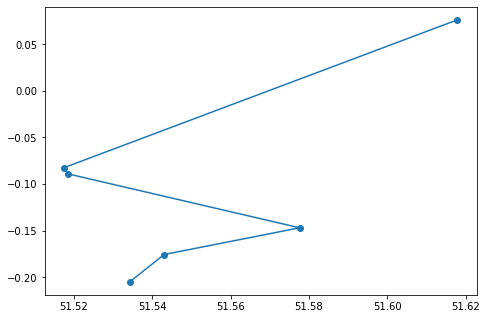

24


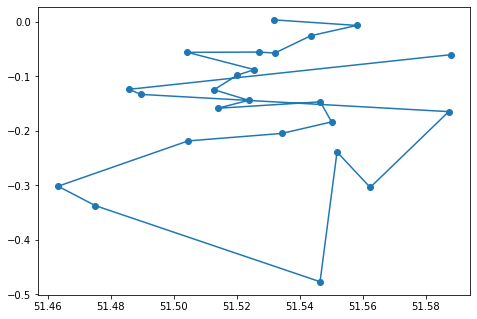

['Abbey Road',
 'Leyton',
 'Hackney Wick',
 'Cambridge Heath',
 'Bethnal Green',
 'Wapping',
 'Old Street',
 'Barbican',
 'Covent Garden',
 'Great Portland Street',
 'Marble Arch',
 'Kentish Town West',
 'Finchley Road and Frognal',
 'Queens Park',
 'Shepherds Bush',
 'Richmond',
 'Isleworth',
 'Uxbridge',
 'Dollis Hill',
 'North Wembley',
 'East Finchley',
 'Pimlico',
 'Vauxhall',
 'Tottenham Hale']

In [5]:
import timeit

test = LondonRailwayMapper()
test.loadStationsAndLines()

test.newRailwayLine(["Queens Park", "Chigwell", "Moorgate", "Swiss Cottage", "Liverpool Street", "Highgate"])

stationsList = ["Abbey Road", "Barbican", "Bethnal Green", "Cambridge Heath", "Covent Garden", "Dollis Hill", "East Finchley", "Finchley Road and Frognal", "Great Portland Street", "Hackney Wick", "Isleworth", "Kentish Town West", "Leyton", "Marble Arch", "North Wembley", "Old Street", "Pimlico", "Queens Park", "Richmond", "Shepherds Bush", "Tottenham Hale", "Uxbridge", "Vauxhall", "Wapping"]

test.newRailwayLine(stationsList)


Use the cell below for all python code needed to test the `LondonRailwayMapper` class above.

In [6]:
import timeit
import random
# minStops API tests

def displayResults(results):
    for key, value in results.items():
        print("Vertex Amount: {0}, Time taken(s): {1}".format(key, value))

# Random graph generator
def generateRandomGraph(vertexAmount, config):
    G = Graph(vertexAmount)
    
    for v in range(vertexAmount):
        # by default we connect all the stations together
        
        if v + 1 < vertexAmount:
            G.addEdge(Edge(v, v + 1, random.randint(1, 200)))
        
        # if the vertex has passed by the specified amount
        # consider to add more than one edge
        if (v + 1) % config["frequency_of_branching"] == 0:
            
            upper = 0
            
            # check if dynamic branching rate is specified
            # if not fall back to fixed branching rate
            if config.get("branching_rate") != None:
                
                upper = vertexAmount // config["branching_rate"]
                
            else:
                
                upper = config["max_branching_station"]
            randomAmountOfEdges = random.randint(config["min_branching_station"], upper)
            
            for _ in range(randomAmountOfEdges):
                
                randomToVertex = random.randint(0, vertexAmount - 1)
                G.addEdge(Edge(v, randomToVertex, random.randint(1, 200)))
                
    return G

def generateRandomGraphs(vertexAmount, config, amount = 5):
    graphs = []
    
    for _ in range(amount):
        
        graphs.append(generateRandomGraph(vertexAmount, config))

    return graphs

def testMinStops(amounts, config):
    result = {}
    
    for amount in amounts:
        
        testGraphs = generateRandomGraphs(amount, config)
        result[amount] = performMinstopsTest(testGraphs)
        
    return result

def performMinstopsTest(graphs):    
    result = 0
    
    for graph in graphs:
        
        t = timeit.Timer(lambda: BFS(graph, 0).lengthTo(99))
        result += t.timeit(1)
    
    return result / 5

config = {
     # Stations till you generate random connections with more than 1 stations, ie every 8 stations
    "frequency_of_branching": 8,
    # Minimum edges to add
    "min_branching_station": 2,
    
    # Upper bound for amount of branching stations as proportion to vertex amount, for example its 100 // 8
    # = 12, the generator will randint between(2, 12)
    "branching_rate": 8
}

verticesToTest = [100, 200, 300, 400, 500,600,700,800,900, 1000]

result = testMinStops(verticesToTest, config)
print("minStops API Test")
print("average time for 5 runs for each vertexAmount")
displayResults(result)

minStops API Test
average time for 5 runs for each vertexAmount
Vertex Amount: 100, Time taken(s): 0.00019011639999999552
Vertex Amount: 200, Time taken(s): 0.0004886189999999679
Vertex Amount: 300, Time taken(s): 0.0009137312000000453
Vertex Amount: 400, Time taken(s): 0.0012403497999999846
Vertex Amount: 500, Time taken(s): 0.001489448400000004
Vertex Amount: 600, Time taken(s): 0.0024821734000000095
Vertex Amount: 700, Time taken(s): 0.003240559600000026
Vertex Amount: 800, Time taken(s): 0.0038330438000000024
Vertex Amount: 900, Time taken(s): 0.00499080700000003
Vertex Amount: 1000, Time taken(s): 0.00594230760000003


In [7]:
# minDistance API tests


# The config works by varying the amount of edges that it will generate
# the one below will consider to generate more than than 
# 1 edge every 8 vertices, this is to simulate the train station
# that is able to connect to more than one line
config = {
    "frequency_of_branching": 8,
    "min_branching_station": 2,
    "branching_rate": 3 # dense graph so branching rate is low here, the lower the denser the graph is
}

def testMinDistance(amounts, config):
    result = {}
    for amount in amounts:
        testGraphs = generateRandomGraphs(amount, config)
        result[amount] = performMinDistanceTest(testGraphs)
    return result

def performMinDistanceTest(graphs):    
    result = 0
    
    for graph in graphs:
        toPoint = random.randrange(1, graph.V)
        withoutDecreaseKey = timeit.Timer(lambda: Dijkstra(graph, 0, False).lengthTo(toPoint))
        result += withoutDecreaseKey.timeit(1)
    return result / 5


testConfigs = {
    "Result for dense graph": {
        "frequency_of_branching": 10,
        "min_branching_station": 8,
        "branching_rate": 10
    },
    "Result for average graph":{
        "frequency_of_branching": 4,
        "min_branching_station": 2,
        "max_branching_station": 8
    },
    "Result for sparse graph": {
        "frequency_of_branching": 14,
        "min_branching_station": 2,
        "max_branching_station": 6
    }
}

def performMultipleConfigTests(verticesToTest, configs):
    for key, currentConfig in configs.items():
        print(key)
        result = testMinDistance(verticesToTest, currentConfig)
        displayResults(result)
        print("\n")
        
performMultipleConfigTests(verticesToTest, testConfigs)

Result for dense graph
Vertex Amount: 100, Time taken(s): 0.0011859682000000759
Vertex Amount: 200, Time taken(s): 0.0035431573999999523
Vertex Amount: 300, Time taken(s): 0.006490408199999909
Vertex Amount: 400, Time taken(s): 0.008514560600000021
Vertex Amount: 500, Time taken(s): 0.014238997000000087
Vertex Amount: 600, Time taken(s): 0.016920084599999986
Vertex Amount: 700, Time taken(s): 0.02075730800000004
Vertex Amount: 800, Time taken(s): 0.027501096199999964
Vertex Amount: 900, Time taken(s): 0.036865065399999966
Vertex Amount: 1000, Time taken(s): 0.040420853799999976


Result for average graph
Vertex Amount: 100, Time taken(s): 0.0011900039999999557
Vertex Amount: 200, Time taken(s): 0.002374274800000009
Vertex Amount: 300, Time taken(s): 0.003778337800000031
Vertex Amount: 400, Time taken(s): 0.006558657800000045
Vertex Amount: 500, Time taken(s): 0.00790131159999996
Vertex Amount: 600, Time taken(s): 0.008117894400000037
Vertex Amount: 700, Time taken(s): 0.012943443999999

In [8]:
# newRailwayLine API tests


# We generate the random latitudes and longitudes, only testing up to 1000 points
# so default value here is 2000
def generateRandomLatitudeAndLongitude(amount = 2000):

    randomLatitudes = random.sample(range(-90000, 90000), amount)
    randomLongitudes = random.sample(range(-180000, 180000), amount)
    return randomLatitudes, randomLongitudes


def performRailwayLineTesting(verticesToTest):
    result = {}
    for vertexAmount in verticesToTest:
        stations = {}
        total = 0
        
        randomLatitudes, randomLongitudes = generateRandomLatitudeAndLongitude()
        
        # add all 2000 latitudes and longitudes to stations dictionary
        # we use pop so there's no chance of having the same random lat long being picked again
        for i in range(2000):
            newStation = StationInfo(i, i, randomLatitudes.pop()/ 1000, randomLongitudes.pop() / 1000)
            stations[i] = newStation
        
        
        # take 5 samples and time the function for each
        # tally up time and store amount
        for _ in range(5):
            t = timeit.Timer(lambda: TwoApprox(random.sample(range(2000), vertexAmount), stations).getPath())
            total += t.timeit(1)
        result[vertexAmount] = total / 5

    return result

results = performRailwayLineTesting([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
displayResults(results)

Vertex Amount: 100, Time taken(s): 0.02492897019999969
Vertex Amount: 200, Time taken(s): 0.07855445460000024
Vertex Amount: 300, Time taken(s): 0.18892884600000012
Vertex Amount: 400, Time taken(s): 0.35249880719999993
Vertex Amount: 500, Time taken(s): 0.5703872495999993
Vertex Amount: 600, Time taken(s): 0.8163876658
Vertex Amount: 700, Time taken(s): 1.1265876803999988
Vertex Amount: 800, Time taken(s): 1.4764647600000003
Vertex Amount: 900, Time taken(s): 1.8864540074000011
Vertex Amount: 1000, Time taken(s): 2.340918656000001


The cell below exemplifies the test code I will invoke on your submission. Do NOT modify it. 


Execution time to load: 0.008

Execution time minStops: 0.001
Execution time minDistance: 0.008
From Baker Street to North Wembley in 6 stops and 8.227662241834029 miles

Execution time minStops: 0.001
Execution time minDistance: 0.006
From Epping to Belsize Park in 17 stops and 20.64961370677551 miles

Execution time minStops: 0.001
Execution time minDistance: 0.007
From Canonbury to Balham in 10 stops and 8.840184381413101 miles

Execution time minStops: 0.002
Execution time minDistance: 0.008
From Vauxhall to Leytonstone in 6 stops and 8.844464870261033 miles
6


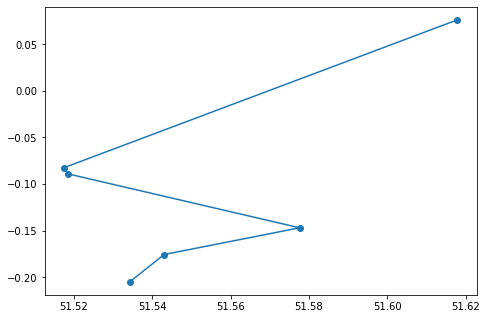



Station list ['Queens Park', 'Chigwell', 'Moorgate', 'Swiss Cottage', 'Liverpool Street', 'Highgate']
New station line ['Queens Park', 'Swiss Cottage', 'Highgate', 'Moorgate', 'Liverpool Street', 'Chigwell']
Total track length from Queens Park to Chigwell : 18.71004286299515 miles
Execution time newLine: 0.108
24


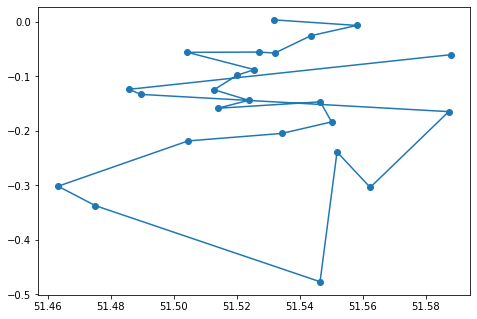



Station list ['Abbey Road', 'Barbican', 'Bethnal Green', 'Cambridge Heath', 'Covent Garden', 'Dollis Hill', 'East Finchley', 'Finchley Road and Frognal', 'Great Portland Street', 'Hackney Wick', 'Isleworth', 'Kentish Town West', 'Leyton', 'Marble Arch', 'North Wembley', 'Old Street', 'Pimlico', 'Queens Park', 'Richmond', 'Shepherds Bush', 'Tottenham Hale', 'Uxbridge', 'Vauxhall', 'Wapping']
New station line ['Abbey Road', 'Leyton', 'Hackney Wick', 'Cambridge Heath', 'Bethnal Green', 'Wapping', 'Old Street', 'Barbican', 'Covent Garden', 'Great Portland Street', 'Marble Arch', 'Kentish Town West', 'Finchley Road and Frognal', 'Queens Park', 'Shepherds Bush', 'Richmond', 'Isleworth', 'Uxbridge', 'Dollis Hill', 'North Wembley', 'East Finchley', 'Pimlico', 'Vauxhall', 'Tottenham Hale']
Total track length from Abbey Road to Tottenham Hale : 4.763530994850844 miles
Execution time newLine: 0.115


In [9]:
# DO NOT MODIFY THIS CELL

import timeit

testMapper = LondonRailwayMapper()

#
# testing the loadStationsAndLines() API 
#
starttime = timeit.default_timer()
testMapper.loadStationsAndLines()
endtime = timeit.default_timer()
print("\nExecution time to load:", round(endtime-starttime,3))

#
# testing the minStops() and minStops() API on a sample of from/to station pairs  
#
fromList = ["Baker Street", "Epping", "Canonbury", "Vauxhall"]
toList = ["North Wembley", "Belsize Park", "Balham", "Leytonstone"]

for i in range(len(fromList)):
    starttime = timeit.default_timer()
    stops = testMapper.minStops(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("\nExecution time minStops:", round(endtime-starttime,3))

    starttime = timeit.default_timer()
    dist = testMapper.minDistance(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("Execution time minDistance:", round(endtime-starttime,3))

    print("From", fromList[i], "to", toList[i], "in", stops, "stops and", dist, "miles")  
    
#
# testing the newRailwayLine() API on a small list of stations  
#
stationsList = ["Queens Park", "Chigwell", "Moorgate", "Swiss Cottage", "Liverpool Street", "Highgate"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))

#
# testing the newRailwayLine() API on a big list of stations  
#
stationsList = ["Abbey Road", "Barbican", "Bethnal Green", "Cambridge Heath", "Covent Garden", "Dollis Hill", "East Finchley", "Finchley Road and Frognal", "Great Portland Street", "Hackney Wick", "Isleworth", "Kentish Town West", "Leyton", "Marble Arch", "North Wembley", "Old Street", "Pimlico", "Queens Park", "Richmond", "Shepherds Bush", "Tottenham Hale", "Uxbridge", "Vauxhall", "Wapping"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))

In [10]:
#### Below are extra stuff

In [11]:
# Generating a graph where there's only one edge per vertex, essentially simulating a train line
# Since most of the stations does not branch to more than 1 station
test = LondonRailwayMapper()
def generateSparseGraph(verticesAmount):
    graphs = []
    for _ in range(0, 5):
        G = Graph(verticesAmount)

        for i in range(verticesAmount):
            if i + 1 < verticesAmount:
                G.addEdge(Edge(i, i + 1, random.randint(1, 200)))
        graphs.append(G)
    
    return graphs


testVerticesAmount = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
def testSparse(amounts):
    result = {}
    for amount in amounts:
        testGraphs = generateSparseGraph(amount)
        result[amount] = performTests(testGraphs)
    return result

def performTests(graphs):    
    result = {"withDecrease": 0, "withoutDecrease": 0}
    
    for graph in graphs:
        toPoint = random.randrange(1, graph.V)
        withoutDecreaseKey = timeit.Timer(lambda: Dijkstra(graph, 0, False).lengthTo(toPoint))
        withDecreaseKey = timeit.Timer(lambda: Dijkstra(graph, 0, True).lengthTo(toPoint))
        
        result["withDecrease"]  += withDecreaseKey.timeit(1)
        result["withoutDecrease"] += withoutDecreaseKey.timeit(1)
    
    result["withDecrease"] = result["withDecrease"] / 5
    result["withoutDecrease"] = result["withoutDecrease"] / 5
    
    return result
    

testSparse(testVerticesAmount)

{100: {'withDecrease': 0.0005013521999998715,
  'withoutDecrease': 0.0004674233999992339},
 200: {'withDecrease': 0.0008610570000001872,
  'withoutDecrease': 0.0008544600000007563},
 300: {'withDecrease': 0.0014587062000003925,
  'withoutDecrease': 0.0014040222000019753},
 400: {'withDecrease': 0.0018926199999995674,
  'withoutDecrease': 0.0017408536000004915},
 500: {'withDecrease': 0.0025742379999996955,
  'withoutDecrease': 0.002385216800000478},
 600: {'withDecrease': 0.0025789153999994595,
  'withoutDecrease': 0.0024175631999995063},
 700: {'withDecrease': 0.002678498000000218,
  'withoutDecrease': 0.0024712018000002446},
 800: {'withDecrease': 0.0029678872000005185,
  'withoutDecrease': 0.0027581218000023},
 900: {'withDecrease': 0.003871373799999844,
  'withoutDecrease': 0.0032434452000003945},
 1000: {'withDecrease': 0.004439250800002981,
  'withoutDecrease': 0.004023494599999821}}

In [12]:
import random


# this simulates how many stations till you reach a station that can transfer to another line
frequency_of_branching = 4
min_branching_station = 2
max_branching_station = 30

def generateRandomGraph(vertexAmount):
    G = Graph(vertexAmount)
    
    for v in range(vertexAmount):
        # by default there needs to be one edge that connects it
        if v + 1 < vertexAmount:
            G.addEdge(Edge(v, v + 1, random.randint(1, 200)))
        
        if (v + 1) % frequency_of_branching == 0:
            randomAmountOfEdges = random.randint(min_branching_station, max_branching_station)
            for _ in range(randomAmountOfEdges):
                randomToVertex = random.randint(0, vertexAmount - 1)
                G.addEdge(Edge(v, randomToVertex, random.randint(1, 200)))
    return G

def generateRandomGraphs(vertexAmount):
    graphs = []
    for _ in range(0, 5):
        graphs.append(generateRandomGraph(vertexAmount))
    return graphs

testVerticesAmount = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
def testAverage(amounts):
    result = {}
    for amount in amounts:
        testGraphs = generateRandomGraphs(amount)
        result[amount] = performTests(testGraphs)
    return result

def performTests(graphs):    
    result = {"withDecrease": 0, "withoutDecrease": 0}
    
    for graph in graphs:
        toPoint = random.randrange(1, graph.V)
        withoutDecreaseKey = timeit.Timer(lambda: Dijkstra(graph, 0, False).lengthTo(toPoint))
        withDecreaseKey = timeit.Timer(lambda: Dijkstra(graph, 0, True).lengthTo(toPoint))
        
        result["withDecrease"]  += withDecreaseKey.timeit(1)
        result["withoutDecrease"] += withoutDecreaseKey.timeit(1)
    
    result["withDecrease"] = result["withDecrease"] / 5
    result["withoutDecrease"] = result["withoutDecrease"] / 5
    
    return result
    

results = testAverage(testVerticesAmount)

Without Decrease 100: 0.00301851559999875
With Decrease 100: 0.003129787599998224


Without Decrease 200: 0.004909056199998929
With Decrease 200: 0.008085893999999882


Without Decrease 300: 0.007956887999999652
With Decrease 300: 0.016647850799999732


Without Decrease 400: 0.01097731799999906
With Decrease 400: 0.029790066799998273


Without Decrease 500: 0.014652818799999068
With Decrease 500: 0.04224353060000112


Without Decrease 600: 0.016641732600001548
With Decrease 600: 0.06051462140000012


Without Decrease 700: 0.02009136580000046
With Decrease 700: 0.08550468739999957


Without Decrease 800: 0.02255745380000036
With Decrease 800: 0.10884713940000097


Without Decrease 900: 0.026491277000000934
With Decrease 900: 0.137564730199999


Without Decrease 1000: 0.030006524000000923
With Decrease 1000: 0.16493069280000155




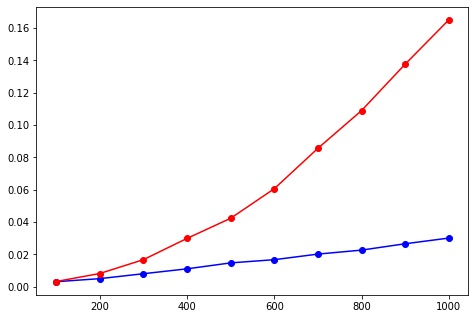

In [13]:
from matplotlib import pyplot as plt


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

x = []
y = []
withDecrease = []
for key in results.keys():
    x.append(key)
    
    print("Without Decrease {0}: {1}".format(key, results[key]["withoutDecrease"]))
    print("With Decrease {0}: {1}".format(key, results[key]["withDecrease"]))
    print("\n")
    
    y.append(results[key]["withoutDecrease"])
    withDecrease.append(results[key]["withDecrease"])
    
ax.plot(x, y, 'bo-', color='blue')

ax.plot(x, withDecrease, 'ro-', color='red')
plt.show()